# X-means clustering of denoised waveforms

In [1]:
import pickle
import tensorflow as tf
from tensorflow.data import Dataset
from matplotlib import pyplot as plt

import denoising as dn

## Loading the data from the pickle files

In [2]:
with open('./spike_waveform_labels.pickle', 'rb') as f:
    labels=pickle.load(f)
labels = labels[::100]

In [3]:
with open('./spike_waveform_data.pickle', 'rb') as f:
    pure = pickle.load(f)

pure = pure[::100]
raw_data = dn.add_noise(pure)

## Denoising

First we apply artificiel noise, then we use an Auto Encoder network to remove the noise.

In [4]:
ds = Dataset.from_tensor_slices(raw_data)
ds = ds.apply(dn.denoise_dataset)

In [5]:
labels_ds = Dataset.from_tensor_slices(labels)

lds = Dataset.zip((ds, labels_ds))

## Comparison of the pure and denoised waveforms

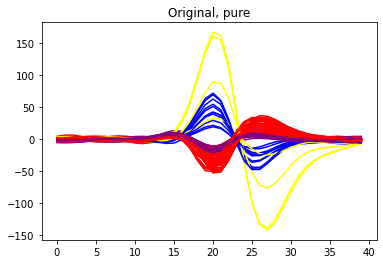

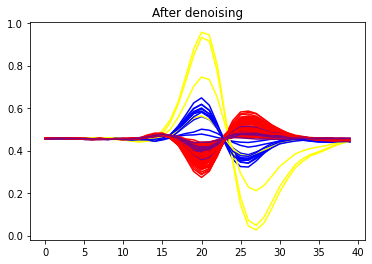

In [6]:

n = 100
take_set = list(lds.take(n).as_numpy_iterator())

color_L = "black red blue green yellow purple pink cyan".split()
# pure
for d, l in zip(pure[:n], labels[:n]):
    plt.plot(d, color=color_L[l], label=l)
plt.title("Original, pure")
plt.show()

# denoised
for e in take_set:
    plt.plot(e[0], c=color_L[e[1]], label=e[1])
plt.title("After denoising")
plt.show()

## Principal Component Analysis

In [7]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np


n_comp = 10
comp_name_L = [f"PC{i}" for i in range(n_comp)]

x = pd.DataFrame.from_records( list(ds.as_numpy_iterator()) )
dfl = pd.DataFrame( labels )


x = x.replace([np.inf, -np.inf], np.nan)
x.fillna(0, inplace=True)

pca = PCA(n_components=n_comp)
principalComponents = pca.fit_transform(x)

pc_df = pd.DataFrame(data = principalComponents
             , columns = comp_name_L)

labeled_df = pd.concat([pc_df, dfl[[0]]], axis = 1)



## Clustering with x-means

In [8]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES

In [9]:

sample = labeled_df[["PC0", "PC1", "PC2"]].values.tolist()

initial_centers = [
    [0, 0, 0],
    [1, 0, 0],
]
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(sample, initial_centers, kmax=5)
xmeans_instance.process()
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()



In [16]:
labeled_df["xmeans_cluster"]=-1
for i, cluster in enumerate(clusters):
    for j in cluster:
        # TODO this have to be redone for every whole run
        # labeled_df.iloc[j, -1] = i+1
        labeled_df.iloc[j, -1] = [1,5,3,2,4][i]  # manually fixing up the label order

## Visualising the clusters in 3D

In [17]:
import plotly.express as px



fig = px.scatter_3d(labeled_df, x='PC0', y='PC1', z='PC2',
              color=0)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

fig = px.scatter_3d(labeled_df, x='PC0', y='PC1', z='PC2',
              color="xmeans_cluster")
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()


## Determining the accuracy

In [18]:
results_df = labeled_df.copy()

results_df["correct"] = 0
results_df.loc[ results_df["xmeans_cluster"] == results_df[0], "correct"]  = 1

df_correct = results_df.loc[ results_df["correct"]== 1]

In [19]:
print(f'Accuracy: {len(df_correct) / len(results_df) :.2%}')

Accuracy: 71.33%
